## Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
import seaborn as sns

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collecting Positives and Anchors

In [ ]:
# Data set we used
#http://vis-www.cs.umass.edu/lfw/

In [ ]:
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'): 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

# Load and Preprocess Images

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [6]:
dir_test = anchor.as_numpy_iterator()

In [7]:
print(dir_test.next())

b'data\\anchor\\90c6b57e-6920-11ee-8b21-3887d5dc365a.jpg'


## Preprocessing - Scale and Resize

In [8]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path) 
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100)) 
    img = img / 255.0
    
    return img

In [9]:
img = preprocess('data\\anchor\\5e3c890f-6920-11ee-aecb-3887d5dc365a.jpg')

In [10]:
img.numpy().max() 

0.8127451

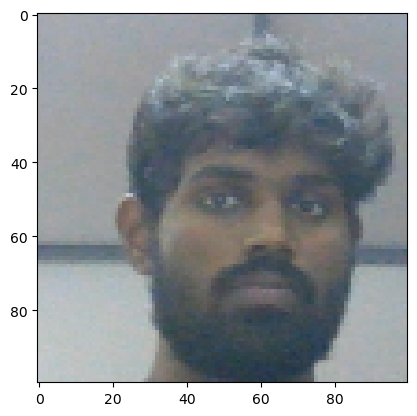

In [11]:
plt.imshow(img)

## Labeling Data sets

In [12]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
samples = data.as_numpy_iterator()

In [14]:
exampple = samples.next()

In [15]:
exampple

(b'data\\anchor\\994551cb-6920-11ee-b6d2-3887d5dc365a.jpg',
 b'data\\positive\\10437b80-6920-11ee-aa83-3887d5dc365a.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [17]:
res = preprocess_twin(*exampple)

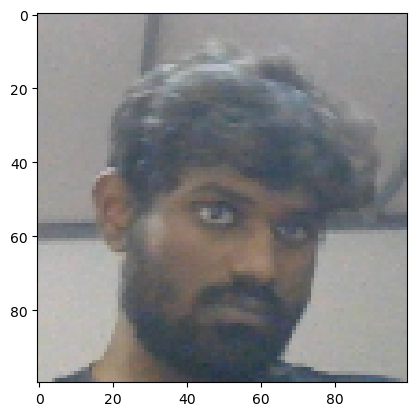

In [18]:
plt.imshow(res[1])

In [19]:
res[2]

1.0

In [20]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [21]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [23]:
inp = Input(shape=(100,100,3), name='input_image')

In [24]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [25]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [26]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [27]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [28]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [29]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [30]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [31]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
     
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [32]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [34]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    

In [35]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding, validation_embedding)

In [36]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [37]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [38]:
siamese_layer = L1Dist()

In [39]:
    distances = siamese_layer(inp_embedding, val_embedding)

In [40]:
classifier = Dense(1, activation='sigmoid')(distances)

In [41]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [42]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [43]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [44]:
def make_siamese_model(): 
    
    
    input_image = Input(name='input_img', shape=(100,100,3))
    
    
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [45]:
siamese_model = make_siamese_model()

In [46]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [47]:
binary_cross_loss = tf.losses.BinaryCrossentropy() 

In [48]:
opt = tf.keras.optimizers.Adam(1e-4) 

In [49]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [50]:
test_batch = train_data.as_numpy_iterator()

In [51]:
batch_1 = test_batch.next()

In [52]:
X = batch_1[:2]


In [53]:
y = batch_1[2]

In [54]:
y

array([0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

In [55]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
       
        X = batch[:2]
        
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [56]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the model

In [ ]:
EPOCHS = 30

In [ ]:
train(train_data, EPOCHS)

## Evaluating Model

In [57]:
from tensorflow.keras.metrics import Precision, Recall

In [58]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [63]:
y_hat = model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[9.9505907e-01],
       [7.1564093e-05],
       [1.0000000e+00],
       [5.1019901e-01],
       [4.6939564e-07],
       [9.9991339e-01],
       [1.3133618e-06],
       [9.9796170e-01],
       [9.9996412e-01],
       [9.8905689e-01],
       [9.9998796e-01],
       [9.9995762e-01],
       [1.0000000e+00],
       [5.5366638e-07],
       [1.3181351e-06],
       [5.3808599e-06]], dtype=float32)

In [73]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o', linestyle='-', color='b')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0.7, 1.01)  # Adjust the y-axis limits to focus on the relevant range
plt.xlim(0.7,1.01)
plt.grid(True)
plt.show()


NameError: name 'recall' is not defined

<Figure size 800x600 with 0 Axes>

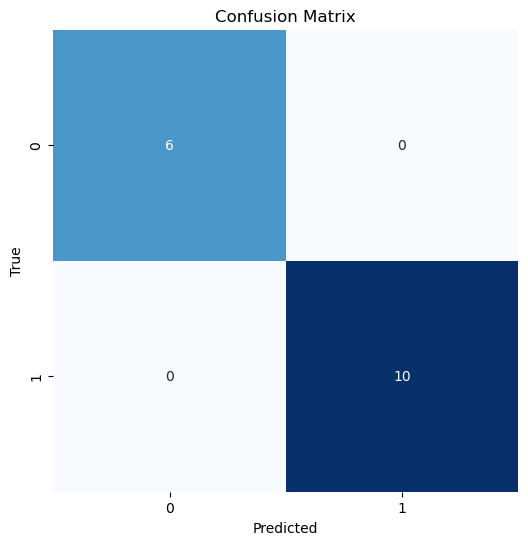

In [65]:
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_hat]
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [66]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]

In [67]:
y_true

array([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [68]:
m = Recall()


m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [69]:
m = Precision()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

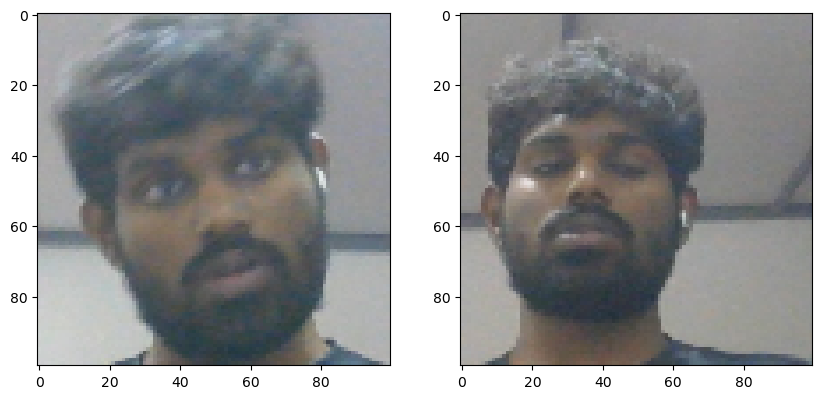

In [70]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[5])

plt.subplot(1,2,2)
plt.imshow(test_val[5])

plt.show()

## Saving Model

In [ ]:
siamese_model.save('siamesemodel.h5')

In [61]:
L1Dist

__main__.L1Dist

In [62]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [74]:
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[9.9505907e-01],
       [7.1564093e-05],
       [1.0000000e+00],
       [5.1019901e-01],
       [4.6939564e-07],
       [9.9991339e-01],
       [1.3133618e-06],
       [9.9796170e-01],
       [9.9996412e-01],
       [9.8905689e-01],
       [9.9998796e-01],
       [9.9995762e-01],
       [1.0000000e+00],
       [5.5366638e-07],
       [1.3181351e-06],
       [5.3808599e-06]], dtype=float32)

In [75]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [76]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [77]:
os.listdir(os.path.join('application_data', 'verification_images'))

['00cc865c-6e9f-11ee-8f6b-3887d5dc365a.jpg',
 '00d8e0f1-6920-11ee-87e8-3887d5dc365a.jpg',
 '00eb8d5c-6920-11ee-aef2-3887d5dc365a.jpg',
 '00f9ab04-6920-11ee-984c-3887d5dc365a.jpg',
 '03d6bdae-6920-11ee-abec-3887d5dc365a.jpg',
 '04abe7ee-6920-11ee-bf8e-3887d5dc365a.jpg',
 '04f1b3cc-6e9f-11ee-a2d3-3887d5dc365a.jpg',
 '057e6e15-6e9f-11ee-95bb-3887d5dc365a.jpg',
 '0a217670-6920-11ee-ac55-3887d5dc365a.jpg',
 '0a380350-6920-11ee-93a9-3887d5dc365a.jpg',
 '0a47da3e-6920-11ee-b40e-3887d5dc365a.jpg',
 '0a552481-6920-11ee-9903-3887d5dc365a.jpg',
 '0a648643-6920-11ee-bbf5-3887d5dc365a.jpg',
 '0a6c2ac5-6920-11ee-a55a-3887d5dc365a.jpg',
 '0a887ec7-6920-11ee-bd12-3887d5dc365a.jpg',
 '0a97b5aa-6920-11ee-9773-3887d5dc365a.jpg',
 '0aa6c83c-6920-11ee-bab7-3887d5dc365a.jpg',
 '0b2354ed-6920-11ee-914f-3887d5dc365a.jpg',
 '0b2ae7db-6920-11ee-8acf-3887d5dc365a.jpg',
 '0b32a0f5-6920-11ee-af66-3887d5dc365a.jpg',
 '0b5d26f0-6920-11ee-8032-3887d5dc365a.jpg',
 '0b6cf079-6920-11ee-bbc6-3887d5dc365a.jpg',
 '0b7fcee9

In [78]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [79]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00cc865c-6e9f-11ee-8f6b-3887d5dc365a.jpg
application_data\verification_images\00d8e0f1-6920-11ee-87e8-3887d5dc365a.jpg
application_data\verification_images\00eb8d5c-6920-11ee-aef2-3887d5dc365a.jpg
application_data\verification_images\00f9ab04-6920-11ee-984c-3887d5dc365a.jpg
application_data\verification_images\03d6bdae-6920-11ee-abec-3887d5dc365a.jpg
application_data\verification_images\04abe7ee-6920-11ee-bf8e-3887d5dc365a.jpg
application_data\verification_images\04f1b3cc-6e9f-11ee-a2d3-3887d5dc365a.jpg
application_data\verification_images\057e6e15-6e9f-11ee-95bb-3887d5dc365a.jpg
application_data\verification_images\0a217670-6920-11ee-ac55-3887d5dc365a.jpg
application_data\verification_images\0a380350-6920-11ee-93a9-3887d5dc365a.jpg
application_data\verification_images\0a47da3e-6920-11ee-b40e-3887d5dc365a.jpg
application_data\verification_images\0a552481-6920-11ee-9903-3887d5dc365a.jpg
application_data\verification_images\0a648643-6920-11ee-bbf5-388

In [80]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    
    detection = np.sum(np.array(results) > detection_threshold)
     
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.9)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()